# **LightGBM model for dynamic data**

We will now develop a LightGBM model to predict on the aggregated dynamic data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import lightgbm as lgb

**Load the data**

In [ ]:
# Load the data
train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/02_lgbm_data/train_aggregated_v2.parquet'
test_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/03_feature_set_3/02_lgbm_data/test_aggregated_v2.parquet'

train_df = pd.read_parquet(train_path)
test_df = pd.read_parquet(test_path)

train_df.head()

subject_id  mode_GCS - Eye Opening  mode_GCS - Motor Response  \
0    10001884                     3.0                        6.0   
1    10002428                     3.0                        6.0   
2    10004235                     4.0                        6.0   
3    10010867                     2.0                        4.0   
4    10011365                     4.0                        6.0   

   mode_Richmond-RAS Scale  mean_Arterial Base Excess  \
0                     -1.0                   1.391908   
1                      0.0                   4.000000   
2                     -1.0                  -5.000000   
3                     -4.0                   1.391908   
4                      0.0                   1.391908   

   mean_Arterial Blood Pressure diastolic  mean_Arterial Blood Pressure mean  \
0                               68.416171                          81.300472   
1                               61.666667                          81.166667   
2                               68.416171                          81.300472   
3                               68.416171                          81.300472   
4                               68.416171                          81.300472   

   mean_Arterial Blood Pressure systolic  mean_Arterial CO2 Pressure  \
0                             117.652355                   40.689586   
1                             118.500000                   43.000000   
2                             117.652355                   37.500000   
3                             117.652355                   40.689586   
4                             117.652355                   40.689586   

   mean_Arterial O2 Saturation  ...  mean_Plateau Pressure  \
0                     96.63619  ...              18.102286   
1                     96.63619  ...              18.102286   
2                     97.00000  ...              18.102286   
3                     96.63619  ...              18.102286   
4                     96.63619  ...              18.102286   

   mean_Platelet Count  mean_Potassium (serum)  mean_Respiratory Rate  \
0           163.460736                4.046379              20.000000   
1           163.460736                4.000000              22.000000   
2            27.000000                4.300000              13.666667   
3           163.460736                4.046379              15.333333   
4           163.460736                4.046379              17.666667   

   mean_Sodium (serum)  mean_Temperature Fahrenheit  \
0           140.103825                    98.862106   
1           143.000000                    98.366667   
2           134.000000                    98.862106   
3           140.103825                    99.300000   
4           140.103825                    98.800000   

   mean_Tidal Volume (observed)  mean_Tidal Volume (spontaneous)   mean_WBC  \
0                    472.138379                       470.899154  11.633799   
1                    380.000000                       355.250000  11.633799   
2                    472.138379                       470.899154  15.300000   
3                    467.000000                       467.000000  11.633799   
4                    344.000000                       344.000000  11.633799   

   extubation_failure  
0                   1  
1                   0  
2                   1  
3                   0  
4                   1  

[5 rows x 36 columns]

**Split the data from the labels**

In [ ]:
# Separate X_train and y_train
y_train = train_df['extubation_failure']
X_train = train_df.drop(['subject_id', 'extubation_failure'], axis=1)

# Separate X_test and y_test
y_test = test_df['extubation_failure']
X_test = test_df.drop(['subject_id', 'extubation_failure'], axis=1)

X_train.head()

mode_GCS - Eye Opening  mode_GCS - Motor Response  mode_Richmond-RAS Scale  \
0                     3.0                        6.0                     -1.0   
1                     3.0                        6.0                      0.0   
2                     4.0                        6.0                     -1.0   
3                     2.0                        4.0                     -4.0   
4                     4.0                        6.0                      0.0   

   mean_Arterial Base Excess  mean_Arterial Blood Pressure diastolic  \
0                   1.391908                               68.416171   
1                   4.000000                               61.666667   
2                  -5.000000                               68.416171   
3                   1.391908                               68.416171   
4                   1.391908                               68.416171   

   mean_Arterial Blood Pressure mean  mean_Arterial Blood Pressure systolic  \
0                          81.300472                             117.652355   
1                          81.166667                             118.500000   
2                          81.300472                             117.652355   
3                          81.300472                             117.652355   
4                          81.300472                             117.652355   

   mean_Arterial CO2 Pressure  mean_Arterial O2 Saturation  \
0                   40.689586                     96.63619   
1                   43.000000                     96.63619   
2                   37.500000                     97.00000   
3                   40.689586                     96.63619   
4                   40.689586                     96.63619   

   mean_Arterial O2 pressure  ...  mean_Peak Insp. Pressure  \
0                 110.926241  ...                      17.0   
1                 127.000000  ...                      20.5   
2                 100.500000  ...                      11.0   
3                 110.926241  ...                      16.0   
4                 110.926241  ...                      12.0   

   mean_Plateau Pressure  mean_Platelet Count  mean_Potassium (serum)  \
0              18.102286           163.460736                4.046379   
1              18.102286           163.460736                4.000000   
2              18.102286            27.000000                4.300000   
3              18.102286           163.460736                4.046379   
4              18.102286           163.460736                4.046379   

   mean_Respiratory Rate  mean_Sodium (serum)  mean_Temperature Fahrenheit  \
0              20.000000           140.103825                    98.862106   
1              22.000000           143.000000                    98.366667   
2              13.666667           134.000000                    98.862106   
3              15.333333           140.103825                    99.300000   
4              17.666667           140.103825                    98.800000   

   mean_Tidal Volume (observed)  mean_Tidal Volume (spontaneous)   mean_WBC  
0                    472.138379                       470.899154  11.633799  
1                    380.000000                       355.250000  11.633799  
2                    472.138379                       470.899154  15.300000  
3                    467.000000                       467.000000  11.633799  
4                    344.000000                       344.000000  11.633799  

[5 rows x 34 columns]

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3760 entries, 0 to 3759
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   mode_GCS - Eye Opening                  3760 non-null   float64
 1   mode_GCS - Motor Response               3760 non-null   float64
 2   mode_Richmond-RAS Scale                 3760 non-null   float64
 3   mean_Arterial Base Excess               3760 non-null   float64
 4   mean_Arterial Blood Pressure diastolic  3760 non-null   float64
 5   mean_Arterial Blood Pressure mean       3760 non-null   float64
 6   mean_Arterial Blood Pressure systolic   3760 non-null   float64
 7   mean_Arterial CO2 Pressure              3760 non-null   float64
 8   mean_Arterial O2 Saturation             3760 non-null   float64
 9   mean_Arterial O2 pressure               3760 non-null   float64
 10  mean_Cardiac Output (CCO)               3760 non-null   floa

In [ ]:
y_train.head()

0    1
1    0
2    1
3    0
4    1
Name: extubation_failure, dtype: int64

In [ ]:
X_test.head()

mode_GCS - Eye Opening  mode_GCS - Motor Response  mode_Richmond-RAS Scale  \
0                     4.0                        2.0                     -5.0   
1                     4.0                        6.0                     -4.0   
2                     4.0                        4.0                     -1.0   
3                     4.0                        6.0                      0.0   
4                     1.0                        1.0                     -5.0   

   mean_Arterial Base Excess  mean_Arterial Blood Pressure diastolic  \
0                   1.391908                               68.416171   
1                   1.391908                               68.416171   
2                   9.000000                               62.000000   
3                   1.391908                               68.416171   
4                   1.391908                               68.000000   

   mean_Arterial Blood Pressure mean  mean_Arterial Blood Pressure systolic  \
0                          81.300472                             117.652355   
1                          81.300472                             117.652355   
2                          79.875000                             131.000000   
3                          81.300472                             117.652355   
4                          77.000000                             126.166667   

   mean_Arterial CO2 Pressure  mean_Arterial O2 Saturation  \
0                   40.689586                     96.63619   
1                   40.689586                     96.63619   
2                   35.500000                     96.63619   
3                   40.689586                     96.63619   
4                   40.689586                     96.63619   

   mean_Arterial O2 pressure  ...  mean_Peak Insp. Pressure  \
0                 110.926241  ...                 11.500000   
1                 110.926241  ...                 20.000000   
2                 108.500000  ...                 18.000000   
3                 110.926241  ...                  9.333333   
4                 110.926241  ...                 21.000000   

   mean_Plateau Pressure  mean_Platelet Count  mean_Potassium (serum)  \
0              18.102286           163.460736                4.046379   
1              18.102286           163.460736                4.046379   
2              18.102286           136.000000                3.900000   
3              18.102286           163.460736                4.046379   
4              18.102286           163.460736                4.046379   

   mean_Respiratory Rate  mean_Sodium (serum)  mean_Temperature Fahrenheit  \
0              26.714286           140.103825                    99.200000   
1              12.750000           140.103825                    99.050000   
2              18.875000           131.000000                    98.400000   
3              20.833333           140.103825                    98.750000   
4              22.000000           140.103825                    98.862106   

   mean_Tidal Volume (observed)  mean_Tidal Volume (spontaneous)   mean_WBC  
0                         340.0                       340.000000  11.633799  
1                         515.0                       470.899154  11.633799  
2                         523.0                       507.000000   9.800000  
3                         577.5                       468.750000  11.633799  
4                         486.0                       486.000000  11.633799  

[5 rows x 34 columns]

In [ ]:
y_test.head()

0    1
1    0
2    0
3    0
4    0
Name: extubation_failure, dtype: int64

**Functions to handle under and over sampling**

In [ ]:
def undersample_data(X, y):
    rus = RandomUnderSampler()
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled, y_resampled

def oversample_data(X, y):
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

# **Experiment 1**

**Hyperparameter tuning using Bayesian Optimisation**

- num_leaves
- max_depth
- min_data_in_leaf
- learning_rate

These parameters are recommended in the LightGBM documentation as "important" parameters (https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)


**Define objective function to cross validate hyperparameters**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


In [ ]:
import optuna

Remove special JSON characters in the column names as these cannot be handled by LightGBM package and need to be replaced.

In [ ]:
def clean_column_names(df):
  # Replace special characters in column names with underscores
  df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
  return df

In [ ]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [ ]:
X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)

print(X_train.columns)
print(X_test.columns)

Index(['mode_GCS_Eye_Opening', 'mode_GCS_Motor_Response',
       'mode_Richmond_RAS_Scale', 'mean_Arterial_Base_Excess',
       'mean_Arterial_Blood_Pressure_diastolic',
       'mean_Arterial_Blood_Pressure_mean',
       'mean_Arterial_Blood_Pressure_systolic', 'mean_Arterial_CO2_Pressure',
       'mean_Arterial_O2_Saturation', 'mean_Arterial_O2_pressure',
       'mean_Cardiac_Output_CCO_', 'mean_Creatinine_serum_', 'mean_EtCO2',
       'mean_Glucose_serum_', 'mean_Heart_Rate', 'mean_Hematocrit_serum_',
       'mean_Hemoglobin', 'mean_Inspired_O2_Fraction', 'mean_Ionized_Calcium',
       'mean_Lactic_Acid', 'mean_Mean_Airway_Pressure', 'mean_Minute_Volume',
       'mean_O2_saturation_pulseoxymetry', 'mean_PH_Arterial_',
       'mean_Peak_Insp_Pressure', 'mean_Plateau_Pressure',
       'mean_Platelet_Count', 'mean_Potassium_serum_', 'mean_Respiratory_Rate',
       'mean_Sodium_serum_', 'mean_Temperature_Fahrenheit',
       'mean_Tidal_Volume_observed_', 'mean_Tidal_Volume_spontaneous_',

In [ ]:
# Remove any _ at the end of column names
X_train.columns = X_train.columns.str.rstrip('_')
X_test.columns = X_test.columns.str.rstrip('_')

print(X_train.columns)
print(X_test.columns)

Index(['mode_GCS_Eye_Opening', 'mode_GCS_Motor_Response',
       'mode_Richmond_RAS_Scale', 'mean_Arterial_Base_Excess',
       'mean_Arterial_Blood_Pressure_diastolic',
       'mean_Arterial_Blood_Pressure_mean',
       'mean_Arterial_Blood_Pressure_systolic', 'mean_Arterial_CO2_Pressure',
       'mean_Arterial_O2_Saturation', 'mean_Arterial_O2_pressure',
       'mean_Cardiac_Output_CCO', 'mean_Creatinine_serum', 'mean_EtCO2',
       'mean_Glucose_serum', 'mean_Heart_Rate', 'mean_Hematocrit_serum',
       'mean_Hemoglobin', 'mean_Inspired_O2_Fraction', 'mean_Ionized_Calcium',
       'mean_Lactic_Acid', 'mean_Mean_Airway_Pressure', 'mean_Minute_Volume',
       'mean_O2_saturation_pulseoxymetry', 'mean_PH_Arterial',
       'mean_Peak_Insp_Pressure', 'mean_Plateau_Pressure',
       'mean_Platelet_Count', 'mean_Potassium_serum', 'mean_Respiratory_Rate',
       'mean_Sodium_serum', 'mean_Temperature_Fahrenheit',
       'mean_Tidal_Volume_observed', 'mean_Tidal_Volume_spontaneous',
       '

In [ ]:
X_train_cleaned = X_train.copy()
X_test_cleaned = X_test.copy()

**Now we can try run the Bayesian Optimisation**

There is a chance that the data is overfitting and so we should implement early stopping as a callback mechanism.

In [ ]:
from lightgbm import early_stopping

In [ ]:
# Give an extensive grid of hyperparameter ranges
param_grid_3 = {
    'num_leaves': [20, 30, 40, 50, 60, 70, 80, 90, 100], # Number of leaves in each tree
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], # Maximum depth of the tree
    'min_data_in_leaf': [20, 30, 40, 50, 60, 70, 80, 90, 100], # Minimum number of data in a leaf
    'learning_rate': [0.0001, 0.001, 0.01, 0.1], # Learning rate
    'sampling_method': ['normal', 'undersample', 'oversample'], # Sampling method
    'lambda_l2': [0.0001, 0.001, 0.01, 0.1] # L2 regularization term
}

In [ ]:
from lightgbm import early_stopping

In [ ]:
!pip install optuna
import optuna

In [ ]:
def objective_wrapper(train_data, param_grid):
    def objective(trial):
        param = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_categorical('num_leaves', param_grid['num_leaves']),
            'max_depth': trial.suggest_categorical('max_depth', param_grid['max_depth']),
            'learning_rate': trial.suggest_categorical('learning_rate', param_grid['learning_rate']),
            'min_data_in_leaf': trial.suggest_categorical('min_data_in_leaf', param_grid['min_data_in_leaf']),
            'lambda_l2': trial.suggest_categorical('lambda_l2', param_grid['lambda_l2'])
        }

        # Choose the sampling method
        sampling_method = trial.suggest_categorical('sampling_method', param_grid['sampling_method'])

        # Resample the training data if necessary
        if sampling_method == 'undersample':
            X_resampled, y_resampled = undersample_data(train_data[0], train_data[1])
        elif sampling_method == 'oversample':
            X_resampled, y_resampled = oversample_data(train_data[0], train_data[1])
        else:
            X_resampled, y_resampled = train_data[0], train_data[1]

        # Create the LightGBM dataset
        train_data_lgb = lgb.Dataset(X_resampled, label=y_resampled)

        # Perform cross-validation with early stopping
        cv_results = lgb.cv(
            param,
            train_data_lgb,
            nfold=5,
            stratified=True,
            shuffle=True,
            metrics='auc',
            seed=42,
            callbacks=[early_stopping(stopping_rounds=10)]
        )

        # Return the best score
        return np.max(cv_results['valid auc-mean'])

    return objective

In [ ]:
import json
import pickle

Run Bayesian Optimisation for 100 trials as carried out for previous models.

In [ ]:
study_exp_4 = optuna.create_study(direction='maximize')
study_exp_4.optimize(objective_wrapper(train_data=(X_train, y_train), param_grid=param_grid_3), n_trials=100)

best_params_exp_4 = study_exp_4.best_params
best_score_exp_4 = study_exp_4.best_value

# Save the best params
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/03_lgbm_model/dynamic_data/best_models/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_params_exp_4, f)

print(f"Best parameters: {best_params_exp_4}")
print(f"Best score: {best_score_exp_4}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
best_params_exp_4

{'num_leaves': 80,
 'max_depth': 9,
 'learning_rate': 0.1,
 'min_data_in_leaf': 30,
 'lambda_l2': 0.01,
 'sampling_method': 'oversample'}

Best score: 0.8321137143417312





**Model training**

Now we can train our optimal model

In [ ]:
# Optimal model
final_model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    boosting_type='gbdt',
    num_leaves=best_params_exp_4['num_leaves'],
    max_depth=best_params_exp_4['max_depth'],
    learning_rate=best_params_exp_4['learning_rate'],
    min_data_in_leaf=best_params_exp_4['min_data_in_leaf'],
    lambda_l2=best_params_exp_4['lambda_l2']
)

final_model

LGBMClassifier(lambda_l2=0.01, max_depth=9, metric='auc', min_data_in_leaf=30,
               num_leaves=80, objective='binary')

In [ ]:
# Prepare the data with the best sampling method
if best_params_exp_4['sampling_method'] == 'undersample':
    X_resampled, y_resampled = undersample_data(X_train, y_train)
elif best_params_exp_4['sampling_method'] == 'oversample':
    X_resampled, y_resampled = oversample_data(X_train, y_train)
else:
    X_resampled, y_resampled = X_train, y_train

In [ ]:
# Train the model
final_model.fit(X_resampled, y_resampled)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Info] Number of positive: 2525, number of negative: 2525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7953
[LightGBM] [Info] Number of data points in the train set: 5050, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with 

LGBMClassifier(lambda_l2=0.01, max_depth=9, metric='auc', min_data_in_leaf=30,
               num_leaves=80, objective='binary')

In [ ]:
# Save the trained model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/03_lgbm_model/dynamic_data/best_models/final_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)

**Evaluate the model**

The test data will not be resampled in the way the training data was as it must reflect the real data.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_lgbm_model(model, X_test, y_test):
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return y_pred_proba

In [ ]:
# Evaluate the model on the held-out test data
evaluate_lgbm_model(final_model, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Accuracy: 0.6801
Precision: 0.5211
Recall (Sensitivity): 0.3204
F1 Score: 0.3968
ROC AUC: 0.5882
Specificity: 0.8560


(0.6801275239107333,
 0.5210526315789473,
 0.32038834951456313,
 0.3967935871743487,
 0.5882005038712056,
 0.8560126582278481)

Accuracy: 0.6801
Precision: 0.5211
Recall (Sensitivity): 0.3204
F1 Score: 0.3968
ROC AUC: 0.5882
Specificity: 0.8560

Ensemble methods

In [ ]:
import pickle

In [ ]:
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/03_lgbm_model/dynamic_data/best_models/final_model.pkl'
with open(model_path, 'rb') as f:
    final_model = pickle.load(f)

In [ ]:
predictions = evaluate_lgbm_model(final_model, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Accuracy: 0.6801
Precision: 0.5211
Recall (Sensitivity): 0.3204
F1 Score: 0.3968
ROC AUC: 0.6404
Specificity: 0.8560


In [ ]:
np.save('/content/drive/MyDrive/MSc_Final_Project/03_model_development/03_feature_set_3/03_lgbm_model/dynamic_data/best_models/predictions.npy', predictions)

**Confusion matrix**

We can plot a confusion matrix to see the distribution of predictions.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=None, normalize=False, title='Confusion Matrix'):
    """
    Plot the confusion matrix using Seaborn heatmap.

    Parameters:
    - y_true: array-like of shape (n_samples,) Ground truth (correct) target values.
    - y_pred: array-like of shape (n_samples,) Estimated targets as returned by a classifier.
    - labels: array-like of shape (n_classes,), default=None List of labels to index the matrix.
    - normalize: bool, default=False If True, normalize the confusion matrix.
    - title: str, default='Confusion Matrix' Title for the heatmap.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Normalize the confusion matrix
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a DataFrame for the confusion matrix
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt=".2f" if normalize else "d", cmap="Blues")
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


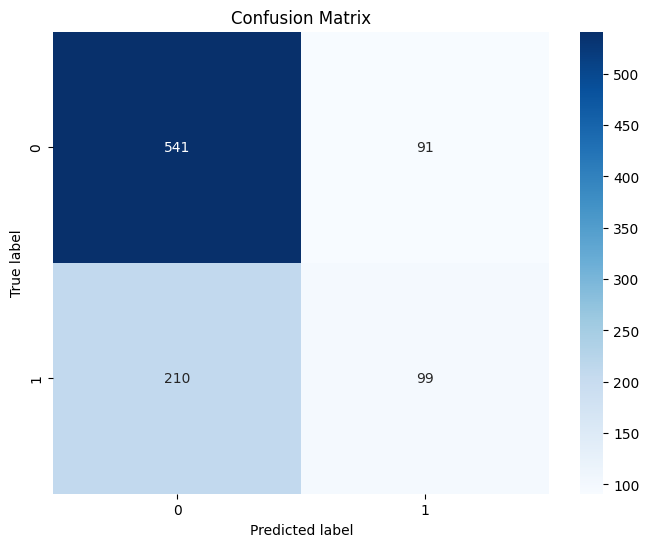

In [ ]:
y_pred = (final_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
labels = [0, 1]
plot_confusion_matrix(y_test, y_pred, labels=labels, normalize=False, title='Confusion Matrix')

# **Model Interpretability**

**Feature importances**

In [ ]:
def plot_feature_importance(model, max_num_features=20):
    # Get the booster from the trained LGBMClassifier
    booster = model.booster_

    # Get feature importances
    importance = booster.feature_importance(importance_type='gain')
    feature_names = booster.feature_name()
    feature_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(max_num_features))
    plt.title('Feature Importance')
    plt.show()

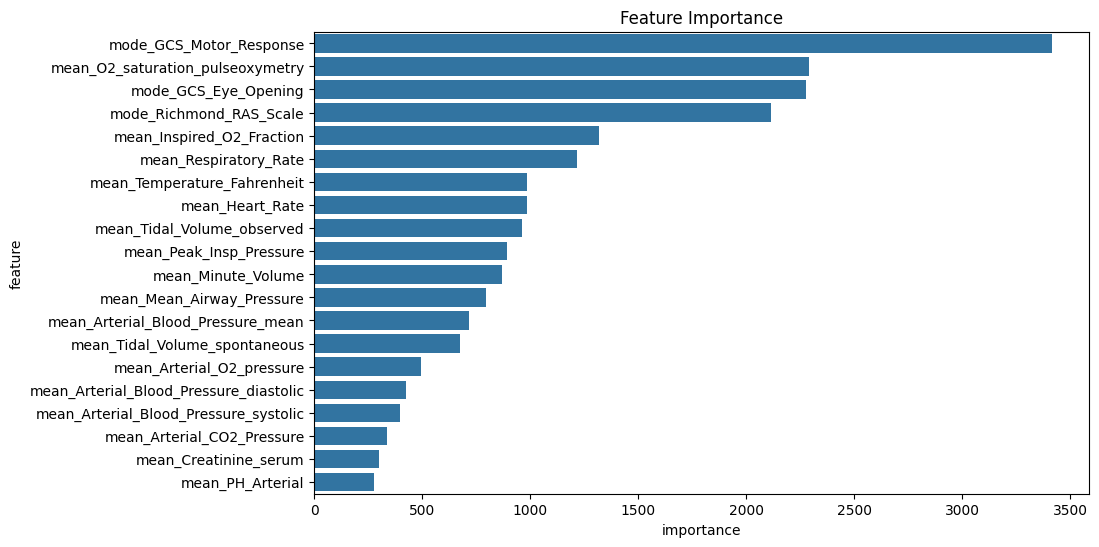

In [ ]:
plot_feature_importance(final_model)

The x-axis refers to gain in feature importance.

Interestingly, SaO2 and FiO2 are also high up here like LSTM.

**Feature ablation**

In [ ]:
def feature_ablation(model, X_train, y_train, X_test, y_test, params, num_boost_round=100):
    # Function to train and evaluate the model
    def train_and_evaluate(X_train, y_train, X_test, y_test):
        train_data = lgb.Dataset(X_train, label=y_train)
        model = lgb.train(params, train_data, num_boost_round=num_boost_round)
        y_pred = model.predict(X_test)
        y_pred_binary = (y_pred >= 0.5).astype(int)

        accuracy = accuracy_score(y_test, y_pred_binary)
        roc_auc = roc_auc_score(y_test, y_pred)
        return accuracy, roc_auc

    # Baseline model with all features
    baseline_accuracy, baseline_roc_auc = train_and_evaluate(X_train, y_train, X_test, y_test)

    # Store results
    results = []

    # Perform feature ablation
    for feature in X_train.columns:
        X_train_ablate = X_train.drop(columns=[feature])
        X_test_ablate = X_test.drop(columns=[feature])

        accuracy, roc_auc = train_and_evaluate(X_train_ablate, y_train, X_test_ablate, y_test)

        results.append({
            'feature': feature,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'accuracy_drop': baseline_accuracy - accuracy,
            'roc_auc_drop': baseline_roc_auc - roc_auc
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Plot the results
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    sns.barplot(x='accuracy_drop', y='feature', data=results_df.sort_values(by='accuracy_drop', ascending=False), ax=axes[0])
    axes[0].set_title('Drop in Accuracy After Feature Ablation')
    axes[0].set_xlabel('Drop in Accuracy')

    sns.barplot(x='roc_auc_drop', y='feature', data=results_df.sort_values(by='roc_auc_drop', ascending=False), ax=axes[1])
    axes[1].set_title('Drop in ROC AUC After Feature Ablation')
    axes[1].set_xlabel('Drop in ROC AUC')

    plt.tight_layout()
    plt.show()

    return results_df

[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Warning] Unknown parameter: sampling_method
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4136
[LightGBM] [Info] Number of data points in the train set: 3760, number of used features: 34
[LightGBM] [Info] Start training from score 0.328457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

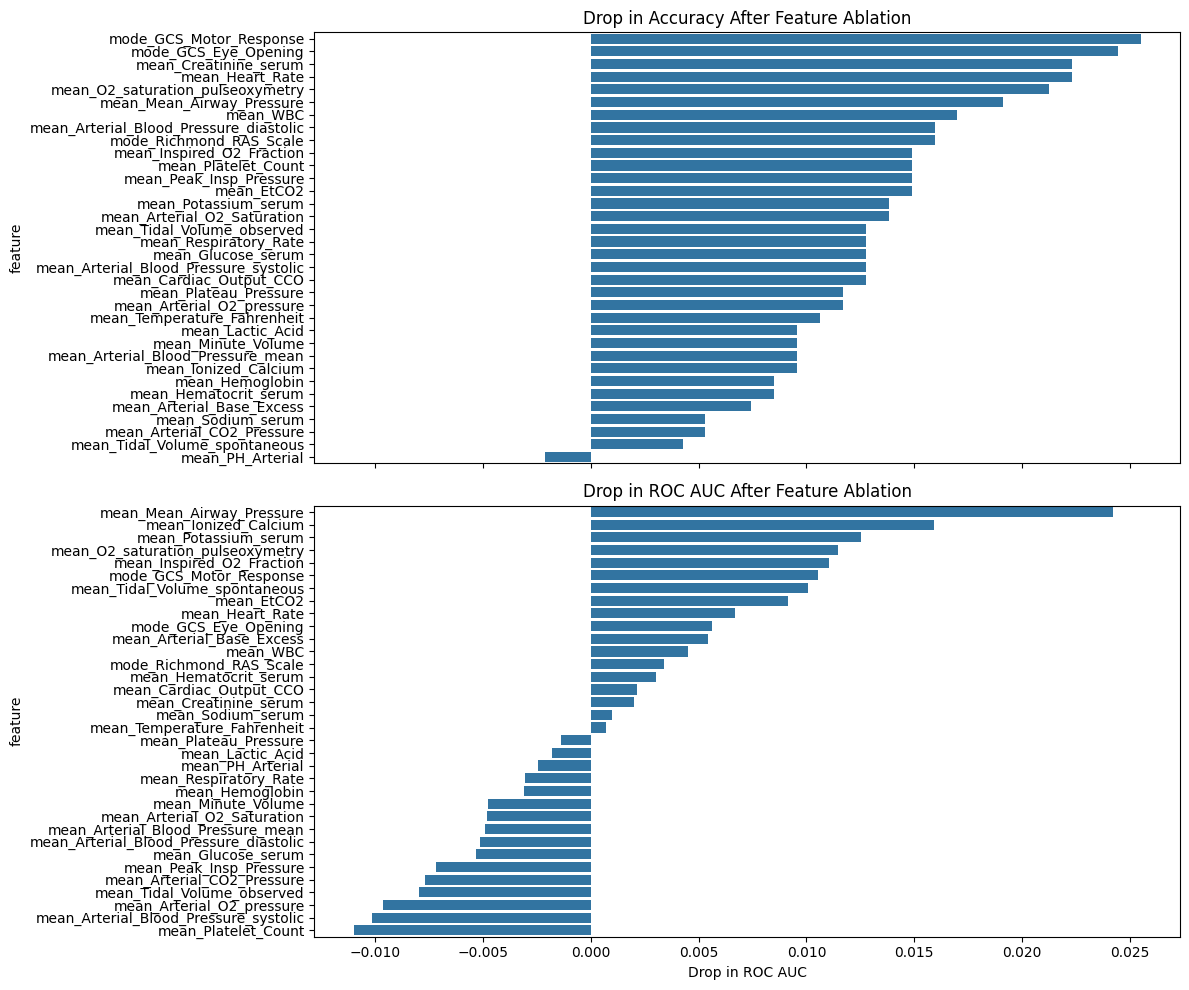

                                   feature  accuracy   roc_auc  accuracy_drop  \
0                     mode_GCS_Eye_Opening  0.680128  0.637848       0.024442   
1                  mode_GCS_Motor_Response  0.679065  0.632906       0.025505   
2                  mode_Richmond_RAS_Scale  0.688629  0.640075       0.015940   
3                mean_Arterial_Base_Excess  0.697131  0.638001       0.007439   
4   mean_Arterial_Blood_Pressure_diastolic  0.688629  0.648606       0.015940   
5        mean_Arterial_Blood_Pressure_mean  0.695005  0.648355       0.009564   
6    mean_Arterial_Blood_Pressure_systolic  0.691817  0.653604       0.012752   
7               mean_Arterial_CO2_Pressure  0.699256  0.651166       0.005313   
8              mean_Arterial_O2_Saturation  0.690755  0.648278       0.013815   
9                mean_Arterial_O2_pressure  0.692880  0.653112       0.011690   
10                 mean_Cardiac_Output_CCO  0.691817  0.641330       0.012752   
11                   mean_Cr

In [ ]:
results_df = feature_ablation(final_model, X_train, y_train, X_test, y_test, best_params_exp_4)
print(results_df)

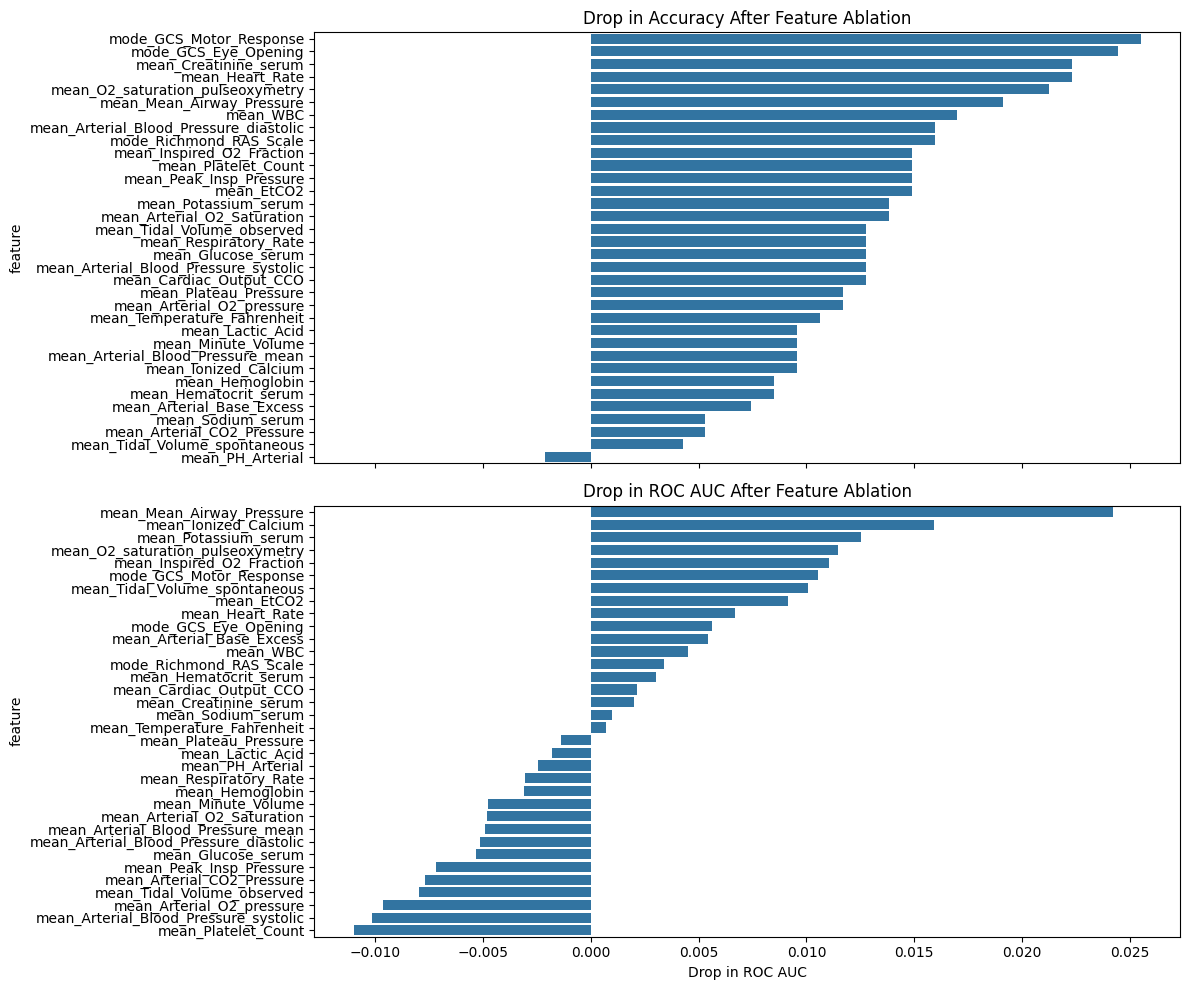

In [ ]:
results_df

feature  accuracy   roc_auc  accuracy_drop  \
0                     mode_GCS_Eye_Opening  0.680128  0.637848       0.024442   
1                  mode_GCS_Motor_Response  0.679065  0.632906       0.025505   
2                  mode_Richmond_RAS_Scale  0.688629  0.640075       0.015940   
3                mean_Arterial_Base_Excess  0.697131  0.638001       0.007439   
4   mean_Arterial_Blood_Pressure_diastolic  0.688629  0.648606       0.015940   
5        mean_Arterial_Blood_Pressure_mean  0.695005  0.648355       0.009564   
6    mean_Arterial_Blood_Pressure_systolic  0.691817  0.653604       0.012752   
7               mean_Arterial_CO2_Pressure  0.699256  0.651166       0.005313   
8              mean_Arterial_O2_Saturation  0.690755  0.648278       0.013815   
9                mean_Arterial_O2_pressure  0.692880  0.653112       0.011690   
10                 mean_Cardiac_Output_CCO  0.691817  0.641330       0.012752   
11                   mean_Creatinine_serum  0.682253  0.641442       0.022317   
12                              mean_EtCO2  0.689692  0.634314       0.014878   
13                      mean_Glucose_serum  0.691817  0.648801       0.012752   
14                         mean_Heart_Rate  0.682253  0.636793       0.022317   
15                   mean_Hematocrit_serum  0.696068  0.640449       0.008502   
16                         mean_Hemoglobin  0.696068  0.646548       0.008502   
17               mean_Inspired_O2_Fraction  0.689692  0.632415       0.014878   
18                    mean_Ionized_Calcium  0.695005  0.627560       0.009564   
19                        mean_Lactic_Acid  0.695005  0.645242       0.009564   
20               mean_Mean_Airway_Pressure  0.685441  0.619239       0.019129   
21                      mean_Minute_Volume  0.695005  0.648222       0.009564   
22        mean_O2_saturation_pulseoxymetry  0.683316  0.631985       0.021254   
23                        mean_PH_Arterial  0.706695  0.645892      -0.002125   
24                 mean_Peak_Insp_Pressure  0.689692  0.650624       0.014878   
25                   mean_Plateau_Pressure  0.692880  0.644858       0.011690   
26                     mean_Platelet_Count  0.689692  0.654459       0.014878   
27                    mean_Potassium_serum  0.690755  0.630904       0.013815   
28                   mean_Respiratory_Rate  0.691817  0.646517       0.012752   
29                       mean_Sodium_serum  0.699256  0.642467       0.005313   
30             mean_Temperature_Fahrenheit  0.693943  0.642753       0.010627   
31              mean_Tidal_Volume_observed  0.691817  0.651423       0.012752   
32           mean_Tidal_Volume_spontaneous  0.700319  0.633398       0.004251   
33                                mean_WBC  0.687566  0.638954       0.017003   

    roc_auc_drop  
0       0.005607  
1       0.010549  
2       0.003380  
3       0.005453  
4      -0.005151  
5      -0.004900  
6      -0.010149  
7      -0.007712  
8      -0.004824  
9      -0.009658  
10      0.002125  
11      0.002012  
12      0.009140  
13     -0.005346  
14      0.006662  
15      0.003006  
16     -0.003093  
17      0.011040  
18      0.015894  
19     -0.001787  
20      0.024216  
21     -0.004767  
22      0.011470  
23     -0.002437  
24     -0.007169  
25     -0.001403  
26     -0.011004  
27      0.012551  
28     -0.003062  
29      0.000988  
30      0.000702  
31     -0.007968  
32      0.010057  
33      0.004501

**SHAP analysis**

In [ ]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


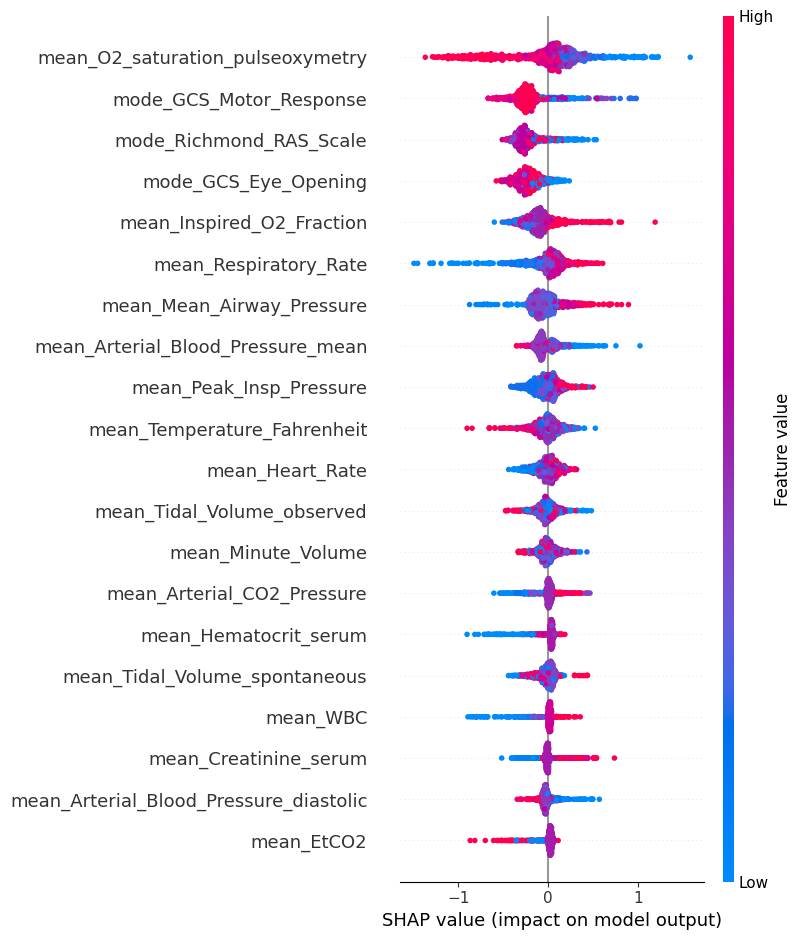

In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.initjs()
shap.summary_plot(shap_values, X_test)

mean_O2_saturation_pulseoxymetry:

High values (red dots) of mean_O2_saturation_pulseoxymetry generally push the prediction towards 0 (extubation success), as indicated by the negative SHAP values.
Low values (blue dots) push the prediction towards 1 (extubation failure).
mean_Peak_Insp_Pressure:

High values of mean_Peak_Insp_Pressure have a mixed impact but mostly push the prediction towards 1 (extubation failure).
Low values seem to have less impact on the model’s prediction.
mean_Inspired_O2_Fraction:

High values push the prediction towards 1 (extubation failure).
Low values push the prediction towards 0 (extubation success).
mean_Respiratory_Rate:

High values push the prediction towards 0 (extubation success).
Low values push the prediction towards 1 (extubation failure).
General Observations
High vs. Low Feature Values:

For some features, high values push the prediction in one direction (either towards extubation success or failure), while low values push it in the opposite direction.


### **Results analysis**

**Best threshold**

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def find_best_threshold_and_evaluate(model, X_test, y_test):
    """
    Find the best threshold for binary classification based on ROC AUC and calculate evaluation metrics.

    Parameters:
    model (LGBMClassifier): The trained LightGBM model.
    X_test (np.array or pd.DataFrame): Test features.
    y_test (np.array or pd.Series): True labels for the test data.

    Returns:
    dict: A dictionary containing the best threshold, ROC AUC, and other evaluation metrics.
    """
    # Get model output (predicted probabilities)
    all_probs = model.predict_proba(X_test)[:, 1]

    # Convert true labels to numpy array
    all_labels = np.array(y_test)

    best_threshold = 0.5
    best_metric_value = 0.0

    thresholds = np.arange(0.0, 1.0, 0.01)  # You can change the step size if needed

    for threshold in thresholds:
        preds = (all_probs >= threshold).astype(int)
        metric_value = roc_auc_score(all_labels, preds)

        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_threshold = threshold

    # Apply the best threshold to get the final predictions
    final_preds = (all_probs >= best_threshold).astype(int)

    # Calculate the final evaluation metrics
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds)
    recall = recall_score(all_labels, final_preds)
    f1 = f1_score(all_labels, final_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
    specificity = recall_score(all_labels, final_preds, pos_label=0)

    metrics = {
        'best_threshold': best_threshold,
        'best_metric_value': best_metric_value,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'specificity': specificity
    }

    print(f"Best Threshold: {best_threshold}")
    print(f"Best Metric Value: {best_metric_value}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return metrics

In [ ]:
find_best_threshold_and_evaluate(final_model, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Best Threshold: 0.37
Best Metric Value: 0.6048067469583385
Accuracy: 0.6291
Precision: 0.4459
Recall: 0.5340
F1 Score: 0.4860
ROC AUC: 0.6404
Specificity: 0.6756


{'best_threshold': 0.37,
 'best_metric_value': 0.6048067469583385,
 'accuracy': 0.6291179596174282,
 'precision': 0.44594594594594594,
 'recall': 0.5339805825242718,
 'f1_score': 0.48600883652430044,
 'roc_auc': 0.6403568063577896,
 'specificity': 0.6756329113924051}

**Plot ROC curve**

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


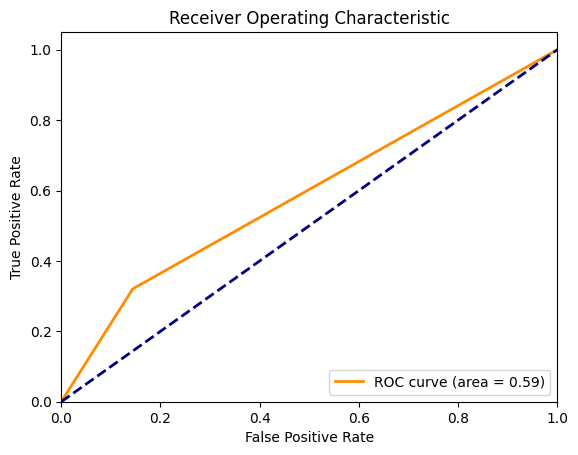

In [ ]:
y_pred_proba = final_model.predict(X_test)
plot_roc_curve(y_test, y_pred_proba)

**Precision-Recall curve**

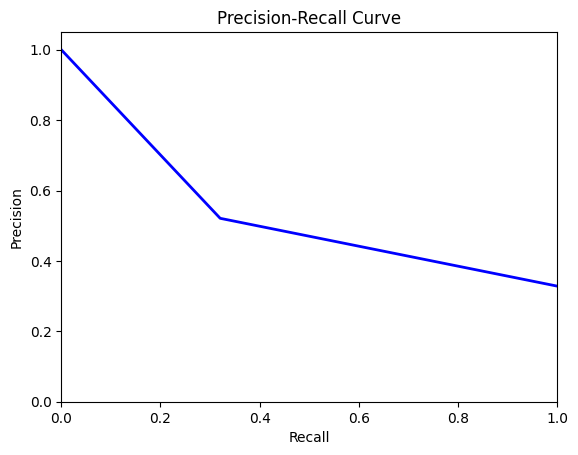

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)

    plt.figure()
    plt.plot(recall, precision, color='b', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

# Plot Precision-Recall curve
plot_precision_recall_curve(y_test, y_pred_proba)

**Display the trained tree**

In [ ]:
!pip install graphviz

In [ ]:
# Plot a single tree
def plot_single_tree(model, tree_index, figsize=(20, 10)):
    ax = lgb.plot_tree(model, tree_index=tree_index, figsize=figsize, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'])
    plt.show()

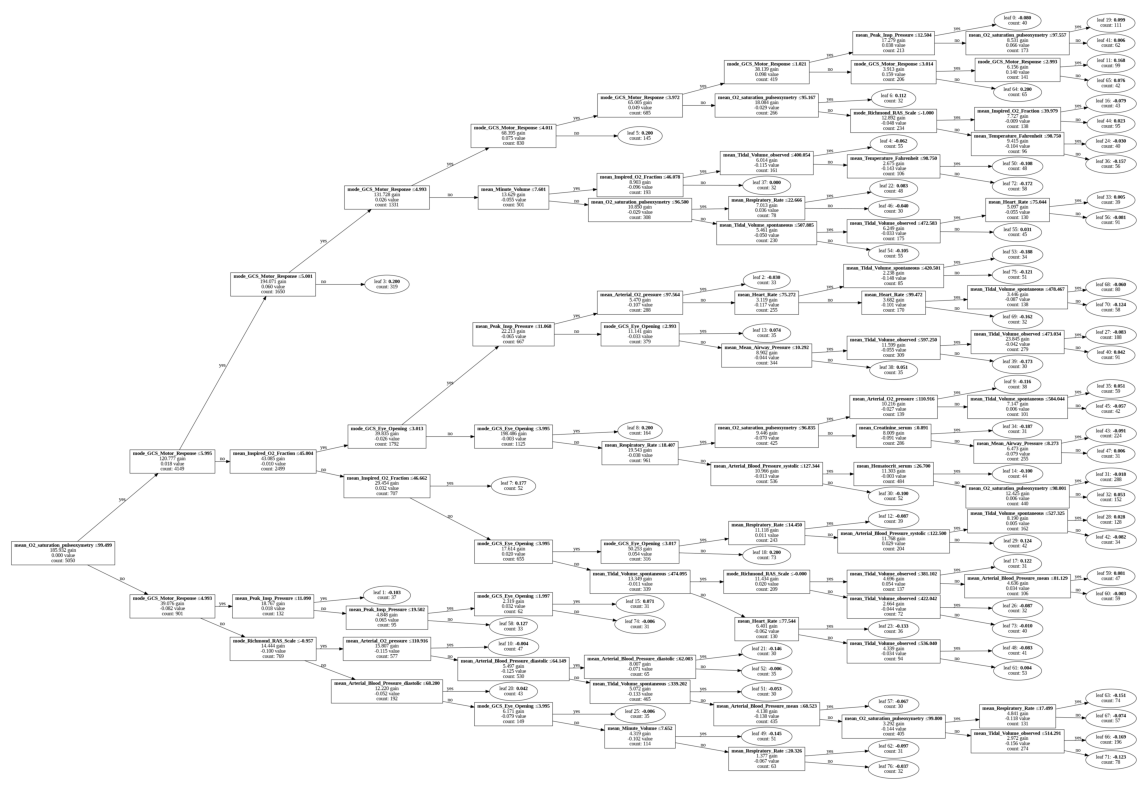

In [ ]:
plot_single_tree(final_model, tree_index=0)

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb

# Function to plot a single tree with high-quality settings
def plot_single_tree_high_quality(model, tree_index, figsize=(20, 10), dpi=300):
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    lgb.plot_tree(model, tree_index=tree_index, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'], ax=ax)
    plt.show()

# Example usage
# Assuming final_model is your trained LightGBM model
plot_single_tree_high_quality(final_model, tree_index=0, figsize=(20, 10), dpi=300)

Output hidden; open in https://colab.research.google.com to view.